In [2]:
import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.utils.data as utils
import torch.nn.init as init
from torch.autograd import Variable

In [3]:
f = pd.read_hdf("Nsubjettiness_mjj.h5")
dt = f.values

In [4]:
idx = dt[:,15]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]

# Normalize inputs#

In [5]:
dt[:,0] = (dt[:,0]-np.mean(dt[:,0]))/np.std(dt[:,0])
dt[:,1] = (dt[:,1]-np.mean(dt[:,1]))/np.std(dt[:,1])
dt[:,2] = (dt[:,2]-np.mean(dt[:,2]))/np.std(dt[:,2])
dt[:,3] = (dt[:,3]-np.mean(dt[:,3]))/np.std(dt[:,3])
dt[:,4] = (dt[:,4]-np.mean(dt[:,4]))/np.std(dt[:,4])
dt[:,5] = (dt[:,5]-np.mean(dt[:,5]))/np.std(dt[:,5])

dt[:,7] = (dt[:,7]-np.mean(dt[:,7]))/np.std(dt[:,7])
dt[:,8] = (dt[:,8]-np.mean(dt[:,8]))/np.std(dt[:,8])
dt[:,9] = (dt[:,9]-np.mean(dt[:,9]))/np.std(dt[:,9])
dt[:,10] = (dt[:,10]-np.mean(dt[:,10]))/np.std(dt[:,10])
dt[:,11] = (dt[:,11]-np.mean(dt[:,11]))/np.std(dt[:,11])
dt[:,12] = (dt[:,12]-np.mean(dt[:,12]))/np.std(dt[:,12])

In [6]:
data = torch.tensor(dt[bkg_idx])
data_train_x_1 = data.t()[0:6].t()
data_train_x_2 = data.t()[7:13].t()
data_train_x = torch.cat((data_train_x_1,data_train_x_2),dim=1)

In [7]:
bs = 128
my_dataset = utils.TensorDataset(data_train_x,data_train_x) # create your datset                                                                         
my_dataloader = utils.DataLoader(my_dataset, batch_size=bs, shuffle=True) # create your dataloader

In [8]:
def reconstruction_loss(x, x_recon):
    recon_loss = F.mse_loss(x_recon, x)
    return recon_loss

In [9]:
def kl_divergence(mu, sigma):
    klds = -0.5*(1 + 2*torch.log(sigma) - mu**2 - sigma**2)
    mean_kld = torch.mean(klds)
    return mean_kld

In [10]:
def reparametrize(mu, sigma):
    std = sigma
    eps = Variable(std.data.new(std.size()).normal_())
    return mu + std*eps

In [11]:
class BetaVAE_H(nn.Module):

    def __init__(self, z_dim=3):
        super(BetaVAE_H, self).__init__()
        self.z_dim = z_dim
        
        self.encoder = nn.Sequential(
        nn.Linear(12, 48),
        nn.LeakyReLU(True),
        nn.Linear(48, 30),
        nn.LeakyReLU(True),
        nn.Linear(30, 20),
        nn.LeakyReLU(True),
        nn.Linear(20, 10),
        nn.LeakyReLU(True),
        nn.Linear(10, 6),
        nn.LeakyReLU(True),
        nn.Linear(6, z_dim*2)
        )
        
        self.decoder = nn.Sequential(
        nn.Linear(z_dim, 6),
        nn.LeakyReLU(True),
        nn.Linear(6, 10),
        nn.LeakyReLU(True),
        nn.Linear(10, 20),
        nn.LeakyReLU(True),
        nn.Linear(20, 30),
        nn.LeakyReLU(True),
        nn.Linear(30,48),
        nn.LeakyReLU(True),
        nn.Linear(48,12)    
        )

    def forward(self, x):
        distributions = self.encoder(x)
        mu = distributions[:,:self.z_dim]
        sigma = F.sigmoid(distributions[:,self.z_dim:])*10+0.1
        z = reparametrize(mu, sigma)
                
        x_recon = self.decoder(z)

        return x_recon, mu, sigma, z

In [12]:
torch.cuda.is_available()

True

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda:0


'GeForce RTX 2080 Ti'

In [14]:
model_VAE = BetaVAE_H().to(device)

In [15]:
lrs = 1e-4
optimizer_VAE = optim.Adam(model_VAE.parameters(), lr = lrs)

In [ ]:
epochs = 30
for epoch in tqdm.notebook.tqdm(range(epochs)):
    model_VAE.train()
    for i, dtt in enumerate(my_dataloader):
        optimizer_VAE.zero_grad()
        
        x_0 = dtt[0].float().cuda()
        x_recon, mu, sigma ,z = model_VAE(x_0)
        
        recon_loss = reconstruction_loss(x_0, x_recon)
        
        mean_kld = kl_divergence(mu, sigma)
        
        beta_vae_loss = 2*recon_loss + mean_kld
        
        beta_vae_loss.backward()
        optimizer_VAE.step()

    if epoch%1==0:
        print(recon_loss.data.cpu().numpy(),mean_kld.data.cpu().numpy(),beta_vae_loss.data.cpu().numpy())

  0%|          | 0/30 [00:00<?, ?it/s]/home/spark/miniconda3/envs/myenv/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  3%|▎         | 1/30 [00:35<17:03, 35.29s/it]

0.84701234 0.17390737 1.8679321


  7%|▋         | 2/30 [01:10<16:31, 35.41s/it]

0.84111595 0.20713148 1.8893634


 10%|█         | 3/30 [01:46<15:59, 35.53s/it]

0.7208182 0.17008862 1.6117251


 13%|█▎        | 4/30 [02:22<15:23, 35.53s/it]

0.8406431 0.18384147 1.8651277


 17%|█▋        | 5/30 [02:57<14:45, 35.43s/it]

0.8320089 0.21503179 1.8790495


 20%|██        | 6/30 [03:33<14:11, 35.46s/it]

0.81534487 0.22028133 1.8509711


 23%|██▎       | 7/30 [04:08<13:36, 35.50s/it]

0.8060202 0.24614196 1.8581823


 27%|██▋       | 8/30 [04:44<13:01, 35.51s/it]

0.7028103 0.23040187 1.6360224


 30%|███       | 9/30 [05:19<12:26, 35.57s/it]

0.7903616 0.26595283 1.846676


 33%|███▎      | 10/30 [05:55<11:52, 35.62s/it]

0.7567658 0.20158039 1.715112


 37%|███▋      | 11/30 [06:31<11:15, 35.57s/it]

0.69138354 0.24234235 1.6251094


 40%|████      | 12/30 [07:06<10:38, 35.50s/it]

0.70716435 0.21349475 1.6278235


 43%|████▎     | 13/30 [07:41<10:01, 35.38s/it]

0.8302278 0.26393044 1.924386


 47%|████▋     | 14/30 [08:17<09:27, 35.45s/it]

0.69762176 0.2424955 1.6377391


 50%|█████     | 15/30 [08:52<08:52, 35.51s/it]

0.7599914 0.25326818 1.773251


 53%|█████▎    | 16/30 [09:27<08:15, 35.39s/it]

0.84020615 0.2894019 1.9698142


 57%|█████▋    | 17/30 [10:03<07:40, 35.40s/it]

0.76905966 0.24685107 1.7849704


 60%|██████    | 18/30 [10:38<07:04, 35.33s/it]

0.71658015 0.20617303 1.6393334


 63%|██████▎   | 19/30 [11:14<06:30, 35.52s/it]

0.7247135 0.1806265 1.6300535


 67%|██████▋   | 20/30 [11:49<05:55, 35.50s/it]

0.7741101 0.23571555 1.7839357


 70%|███████   | 21/30 [12:25<05:19, 35.50s/it]

0.69655824 0.21611665 1.6092331


 73%|███████▎  | 22/30 [13:01<04:45, 35.70s/it]

0.96849823 0.24343881 2.1804352


 77%|███████▋  | 23/30 [13:36<04:08, 35.56s/it]

0.8277762 0.26224816 1.9178005


 80%|████████  | 24/30 [14:11<03:32, 35.45s/it]

0.7194715 0.21909338 1.6580365


 83%|████████▎ | 25/30 [14:48<02:58, 35.71s/it]

0.7283528 0.2111158 1.6678214


In [16]:
data_bkg = torch.tensor(dt[bkg_idx])
data_signal = torch.tensor(dt[signal_idx])

In [17]:
data_train_x_1 = data_bkg.t()[0:6].t()
data_train_x_2 = data_bkg.t()[7:13].t()
data_test_bkg = torch.cat((data_train_x_1,data_train_x_2),dim=1)

In [18]:
data_train_x_1 = data_signal.t()[0:6].t()
data_train_x_2 = data_signal.t()[7:13].t()
data_test_signal = torch.cat((data_train_x_1,data_train_x_2),dim=1)

In [19]:
model_VAE.eval()

BetaVAE_H(
  (encoder): Sequential(
    (0): Linear(in_features=12, out_features=48, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=48, out_features=30, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=30, out_features=20, bias=True)
    (5): LeakyReLU(negative_slope=True)
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): LeakyReLU(negative_slope=True)
    (8): Linear(in_features=10, out_features=6, bias=True)
    (9): LeakyReLU(negative_slope=True)
    (10): Linear(in_features=6, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=6, out_features=10, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=10, out_features=20, bias=True)
    (5): LeakyReLU(negative_slope=True)
    (6): Linear(in_features=20, out_features=30, bias=True)
    (7): LeakyReLU(n

In [20]:
reconstructed,_,_,_ = model_VAE(data_test_bkg.float().cuda())

In [21]:
reconstructed_sig,_,_,_ = model_VAE(data_test_signal.float().cuda())

In [26]:
loss_bkg = torch.mean((reconstructed-data_test_bkg.float().cuda())**2,dim=1).data.cpu().numpy()
#loss_bkg = loss_bkg[np.where(loss_bkg<2)]
loss_signal = torch.mean((reconstructed_sig-data_test_signal.float().cuda())**2,dim=1).data.cpu().numpy()
#loss_signal = loss_signal[np.where(loss_signal<2)]

In [27]:
def get_tpr_fpr(sigloss,bkgloss,aetype='sig'):
    bins = np.linspace(0,50,1001)
    tpr = []
    fpr = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    return tpr,fpr    

In [29]:
bkg_tpr, bkg_fpr = get_tpr_fpr(loss_signal,loss_bkg,aetype='bkg')

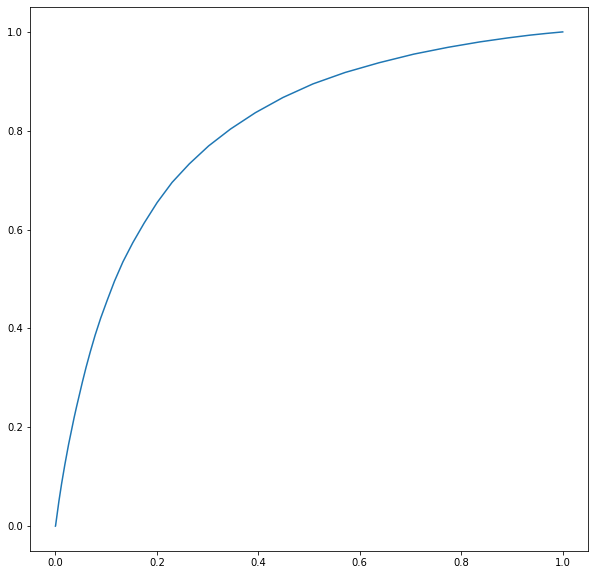

In [30]:
plt.plot(bkg_fpr,bkg_tpr,label='Bkg betaVAE')


In [31]:
np.save('/data/t3home000/spark/QUASAR/new_flows/betaVAE_bkgAE_fpr.npy',bkg_fpr)
np.save('/data/t3home000/spark/QUASAR/new_flows/betaVAE_bkgAE_tpr.npy',bkg_tpr)

In [23]:
loss_sig_truncate = loss_signal[np.where(loss_signal<5)[0]]
loss_bkg_truncate = loss_bkg[np.where(loss_bkg<5)[0]]

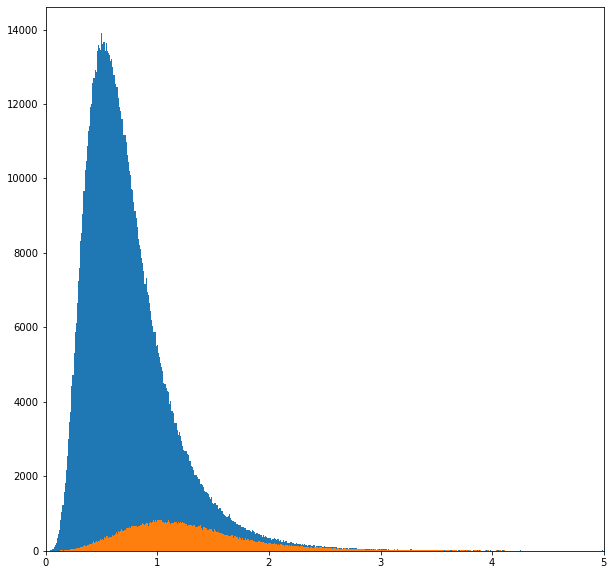

In [25]:
plt.rcParams["figure.figsize"] = (10,10)
plt.hist(loss_bkg_truncate,500)
plt.hist(loss_sig_truncate,500)
plt.xlim([0,5])
#plt.ylim([0,2000])
plt.savefig('BetaVAE_loss_distribution_zoomed.png')


In [30]:
total_data = torch.tensor(dt)
total_data_train_x_1 = total_data.t()[0:6].t()
total_data_train_x_2 = total_data.t()[7:13].t()
total_data_selection = torch.cat((total_data_train_x_1,total_data_train_x_2),dim=1)

In [31]:
reconstructed_tot,_,_,_ = model_VAE(total_data_selection.float().cuda())

In [32]:
loss_total = torch.mean((reconstructed_tot-total_data_selection.float().cuda())**2,dim=1).data.cpu().numpy()


In [40]:
TEST_selection_based_on_bkg_idx = np.where((loss_total>1.5))[0]

In [41]:
TEST_selection_based_on_bkg_selectedmass = dt[TEST_selection_based_on_bkg_idx,14]

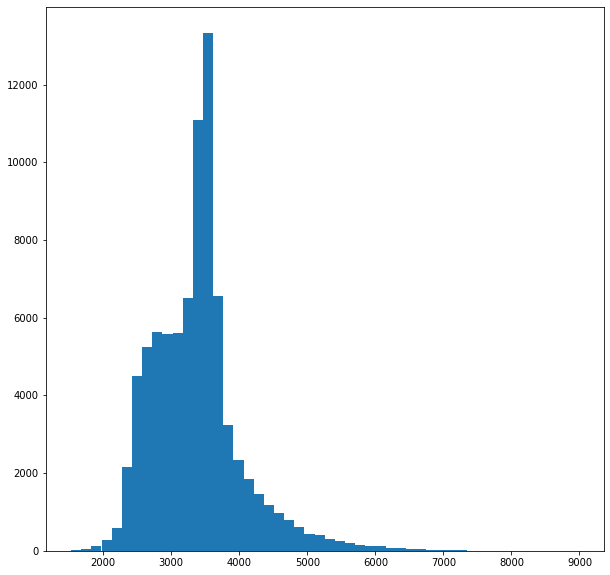

In [43]:
plt.rcParams["figure.figsize"] = (10,10)
plt.hist(TEST_selection_based_on_bkg_selectedmass,50)
plt.savefig('BetaVAE_with_bkgAE.png')